# Introductory Tutorial

## Tutorial Description

[Mesa](https://github.com/projectmesa/mesa) is a Python framework for [agent-based modeling](https://en.wikipedia.org/wiki/Agent-based_model).  Getting started with Mesa is easy. In this tutorial, we will walk through creating a simple model and progressively add functionality which will illustrate Mesa's core features.

**Note:** This tutorial is a work-in-progress. If you find any errors or bugs, or just find something unclear or confusing, [let us know](https://github.com/projectmesa/mesa/issues)!

The base for this tutorial is a very simple model of agents exchanging money. Next, we add *space* to allow agents move. Then, we'll cover two of Mesa's analytic tools: the *data collector* and *batch runner*. After that, we'll add an *interactive visualization* which lets us watch the model as it runs. Finally, we go over how to write your own visualization module, for users who are comfortable with JavaScript.

You can also find all the code this tutorial describes in the **examples/boltzmann_wealth_model** directory of the Mesa repository.

## Sample Model Description

The tutorial model is a very simple simulated agent-based economy, drawn from econophysics and presenting a statistical mechanics approach to wealth distribution [Dragulescu2002](#ref). The rules of our tutorial model:

1. There are some number of agents.
2. All agents begin with 1 unit of money.
3. At every step of the model, an agent gives 1 unit of money (if they have it) to some other agent.

Despite its simplicity, this model yields results that are often unexpected to those not familiar with it. For our purposes, it also easily demonstrates Mesa's core features.

Let's get started.

### Installation

If you are not using the [binder](https://mybinder.org/) instance, please follow the instructions below. 

To start, install Mesa. We recommend doing this in a [virtual environment](https://virtualenvwrapper.readthedocs.org/en/stable/), but make sure your environment is set up with Python 3. Mesa requires Python3 and does not work in Python 2 environments.

To install Mesa, simply:

```bash
    $ pip install mesa
```

When you do that, it will install Mesa itself, as well as any dependencies that aren't in your setup yet. Additional dependencies required by this tutorial can be found in the **examples/boltzmann_wealth_model/requirements.txt** file, which can be installed directly form the github repository by running:

```bash
    $ pip install -r https://raw.githubusercontent.com/projectmesa/mesa/main/examples/boltzmann_wealth_model/requirements.txt  
```

This will install the dependencies listed in the requirements.txt file which are:  
- jupyter (Ipython interactive notebook)  
- matplotlib (Python's visualization library)  
- mesa (this ABM library -- if not installed)  
- numpy (Python's numerical python library)  

## Building a sample model

Once Mesa is installed, you can start building our model. You can write models in two different ways:

1. Write the code in its own file with your favorite text editor, or
2. Write the model interactively in [Jupyter Notebook](http://jupyter.org/) cells.

Either way, it's good practice to put your model in its own folder -- especially if the project will end up consisting of multiple files (for example, Python files for the model and the visualization, a Notebook for analysis, and a Readme with some documentation and discussion).

Begin by creating a folder, and either launch a Notebook or create a new Python source file.  We will use the name `money_model.py` here.



### Setting up the model

To begin writing the model code, we start with two core classes: one for the overall model, the other for the agents. The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Each instantiation of the model class will be a specific model run. Each model will contain multiple agents, all of which are instantiations of the agent class. Both the model and agent classes are child classes of Mesa's generic `Model` and `Agent` classes.

Each agent has only one variable: how much wealth it currently has. (Each agent will also have a unique identifier (i.e., a name), stored in the `unique_id` variable. Giving each agent a unique id is a good practice when doing agent-based modeling.)

There is only one model-level parameter: how many agents the model contains. When a new model is started, we want it to populate itself with the given number of agents.

The beginning of both classes looks like this:

In [1]:
from mesa import Agent, Model

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### Adding the scheduler

Time in most agent-based models moves in steps, sometimes also called **ticks**. At each step of the model, one or more of the agents -- usually all of them -- are activated and take their own step, changing internally and/or interacting with one another or the environment.

The **scheduler** is a special model component which controls the order in which agents are activated. For example, all the agents may activate in the same order every step; their order might be shuffled; we may try to simulate all the agents acting at the same time; and more. Mesa offers a few different built-in scheduler classes, with a common interface. That makes it easy to change the activation regime a given model uses, and see whether it changes the model behavior. This may not seem important, but scheduling patterns can have an impact on your results [Comer2014].

For now, let's use one of the simplest ones: `RandomActivation`, which activates all the agents once per step, in random order. Every agent is expected to have a ``step`` method. The step method is the action the agent takes when it is activated by the model schedule. We add an agent to the schedule using the `add` method; when we call the schedule's `step` method, the model shuffles the order of the agents, then activates and executes each agent's ```step``` method.

With that in mind, the model code with the scheduler added looks like this:

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print ("Hi, I am agent " + str(self.unique_id) +".")

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

At this point, we have a model which runs -- it just doesn't do anything. You can see for yourself with a few easy lines. If you've been working in an interactive session, you can create a model object directly. Otherwise, you need to open an interactive session in the same directory as your source code file, and import the classes. For example, if your code is in `money_model.py`:

```python
from money_model import MoneyModel
```
Then create the model object, and run it for one step:

In [4]:
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 7.
Hi, I am agent 3.
Hi, I am agent 1.
Hi, I am agent 8.
Hi, I am agent 6.
Hi, I am agent 5.
Hi, I am agent 9.
Hi, I am agent 4.
Hi, I am agent 2.
Hi, I am agent 0.


#### Exercise
    
Try modifying the code above to have every agent print out its `wealth` when it is activated. Run a few steps of the model to see how the agent activation order is shuffled each step.

### Agent Step

Now we just need to have the agents do what we intend for them to do: check their wealth, and if they have the money, give one unit of it away to another random agent. To allow the agent to choose another agent at random, we use the ``model.random`` random-number generator. This works just like Python's ``random`` module, but with a fixed seed set when the model is instantiated, that can be used to replicate a specific model run later.

To pick an agent at random, we need a list of all agents. Notice that there isn't such a list explicitly in the model. The scheduler, however, does have an internal list of all the agents it is scheduled to activate.

With that in mind, we rewrite the agent `step` method, like this:

In [5]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

### Running your first model

With that last piece in hand, it's time for the first rudimentary run of the model.

If you've written the code in its own file (`money_model.py` or a different name), launch an interpreter in the same directory as the file (either the plain Python command-line interpreter, or the IPython interpreter), or launch a Jupyter Notebook there. Then import the classes you created. (If you wrote the code in a Notebook, obviously this step isn't necessary).

```python
from money_model import *
```

Now let's create a model with 10 agents, and run it for 10 steps.

In [6]:
model = MoneyModel(10)
for i in range(10):
    model.step()

Next, we need to get some data out of the model. Specifically, we want to see the distribution of the agent's wealth. We can get the wealth values with list comprehension, and then use matplotlib (or another graphics library) to visualize the data in a histogram.

If you are running from a text editor or IDE, you'll also need to add this line, to make the graph appear.

```python
plt.show()
```

(array([3., 0., 0., 5., 0., 0., 1., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

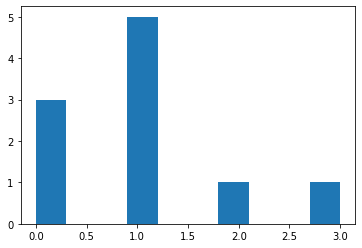

In [7]:
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

You'll should see something like the distribution above. Yours will almost certainly look at least slightly different, since each run of the model is random, after all.

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

(array([436., 303., 144.,  72.,  34.,  11.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

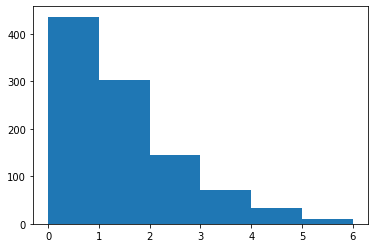

In [8]:
all_wealth = []
#This runs the model 100 times, each model executing 10 steps. 
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()
    
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

This runs 100 instantiations of the model, and runs each for 10 steps. (Notice that we set the histogram bins to be integers, since agents can only have whole numbers of wealth). This distribution looks a lot smoother. By running the model 100 times, we smooth out some of the 'noise' of randomness, and get to the model's overall expected behavior.

This outcome might be surprising. Despite the fact that all agents, on average, give and receive one unit of money every step, the model converges to a state where most agents have a small amount of money and a small number have a lot of money.

### Adding space

Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently [toroidal](https://en.wikipedia.org/wiki/Toroidal_graph), meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Let's add a simple spatial element to our model by putting our agents on a grid and make them walk around at random. Instead of giving their unit of money to any random agent, they'll give it to an agent on the same cell.

Mesa has two main types of grids: `SingleGrid` and `MultiGrid`. `SingleGrid` enforces at most one agent per cell; `MultiGrid` allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use `MultiGrid`.

In [9]:
from mesa.space import MultiGrid

We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let's make width and height model parameters, in addition to the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid's `place_agent` method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.

In [10]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

Under the hood, each agent's position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a `pos` variable with an (x, y) coordinate tuple. The `place_agent` method adds the coordinate to the agent automatically.

Now we need to add to the agents' behaviors, letting them move around and only give money to other agents in the same cell.

First let's handle movement, and have the agents move to a neighboring cell. The grid object provides a `move_agent` method, which like you'd imagine, moves an agent to a given cell. That still leaves us to get the possible neighboring cells to move to. There are a couple ways to do this. One is to use the current coordinates, and loop over all coordinates +/- 1 away from it. For example:

```python
neighbors = []
x, y = self.pos
for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        neighbors.append((x+dx, y+dy))
```

But there's an even simpler way, using the grid's built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: [Moore](https://en.wikipedia.org/wiki/Moore_neighborhood) (includes all 8 surrounding squares), and [Von Neumann](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood)(only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

With that in mind, the agent's `move` method looks like this:

```python
class MoneyAgent(Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
```

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid's `get_cell_list_contents` method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

```python
class MoneyAgent(Agent):
    #...
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
```

And with those two methods, the agent's ``step`` method becomes:

```python
class MoneyAgent(Agent):
    # ...
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
```

Now, putting that all together should look like this:

In [11]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=True, 
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()



Let's create a model with 50 agents on a 10x10 grid, and run it for 20 steps.

In [12]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

Now let's use matplotlib and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object's `coord_iter()` feature, which lets us loop over every cell in the grid, giving us each cell's coordinates and contents in turn.

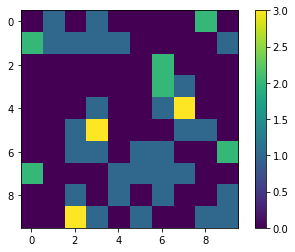

In [13]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()

### Collecting Data

So far, at the end of every model run, we've had to go and write our own code to get the data out of the model. This has two problems: it isn't very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we'd have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s `collect` method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s `unique_id`.

Let's add a DataCollector to the model, and collect two variables. At the agent level, we want to collect every agent's wealth at every step. At the model level, let's measure the model's [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), a measure of wealth inequality.

In [14]:
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, 
            moore=True, 
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent's wealth, associating each with the current step.

We run the model just as we did above. Now is when an interactive session, especially via a Notebook, comes in handy: the DataCollector can export the data it's collected as a pandas DataFrame, for easy interactive analysis.

In [15]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

To get the series of Gini coefficients as a pandas DataFrame:

<AxesSubplot:>

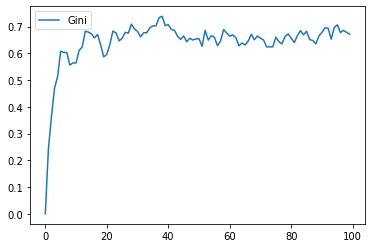

In [16]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

Similarly, we can get the agent-wealth data:

In [17]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

You'll see that the DataFrame's index is pairings of model step and agent ID. You can analyze it the way you would any other DataFrame. For example, to get a histogram of agent wealth at the model's end:

<AxesSubplot:>

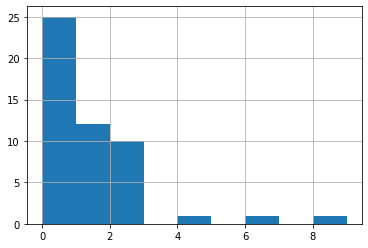

In [18]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

Or to plot the wealth of a given agent (in this example, agent 14):

<AxesSubplot:xlabel='Step'>

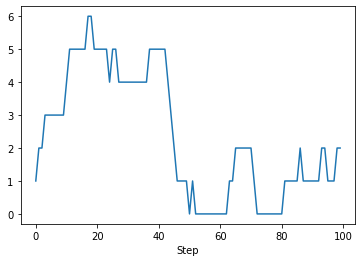

In [19]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

### Batch Run

Like we mentioned above, you usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a BatchRunner class which automates it for you.

The BatchRunner also requires an additional variable `self.running` for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

In [20]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

We instantiate a BatchRunner with a model class to run, and two dictionaries: one of the fixed parameters (mapping model arguments to values) and one of varying parameters (mapping each parameter name to a sequence of values for it to take).  The BatchRunner also takes an argument for how many model instantiations to create and run at each combination of parameter values, and how many steps to run each instantiation for. Finally, like the DataCollector, it takes dictionaries of model- and agent-level reporters to collect. Unlike the DataCollector, it won't collect the data every step of the model, but only at the end of each run.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the BatchRunner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps.* 


We have it collect the final Gini coefficient value.

Now, we can set up and run the BatchRunner:

*The total number of runs is 245. That is 10 agents to 490 increasing by 10, making 49 agents populations. Each agent population is then run 5 times (49 * 5) for 245 iterations 

In [21]:
from mesa.batchrunner import BatchRunner

In [22]:
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel, 
                        variable_params,
                        fixed_params,
                        iterations=5, 
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [01:18,  3.11it/s]


BatchRunner has two ways to collect data.

First, one can pass model collection via BatchRunner as seen above with output below.

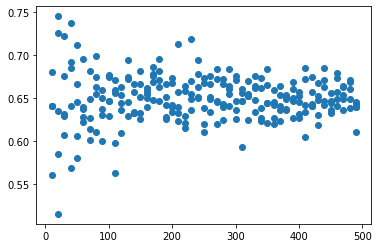

In [23]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

Notice that each row is a model run, and gives us the parameter values associated with that run. We can use  this data to view a scatter-plot comparing the number of agents to the final Gini.

Second, BatchRunner can call the datacollector from the model. The output is a dictionary, where each key is the parameters with the iteration number and then the datacollector dataframe. So in this model (<#number of agents>, <iteration#>).

In [24]:
#Get the Agent DataCollection
data_collector_agents = batch_run.get_collector_agents()

data_collector_agents[(10,2)]

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   5             0
     6             0
     7             0
     8             0
     9             1

[1000 rows x 1 columns]

In [25]:
#Get the Model DataCollection. 

data_collector_model = batch_run.get_collector_model()

data_collector_model[(10,1)]

,Gini
0,0.00
1,0.00
2,0.32
3,0.32
4,0.46
...,...
95,0.64
96,0.64
97,0.64
98,0.64


### Happy Modeling!

This document is a work in progress.  If you see any errors, exclusions or have any problems please contact [us](https://github.com/projectmesa/mesa/issues).

<a id = "ref"></a>

`virtual environment`: http://docs.python-guide.org/en/latest/dev/virtualenvs/

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.